<a href="https://colab.research.google.com/github/balajibvns442/Final_Year_Project/blob/basics/CNN_models/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import os
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define Paths and Parameters
data_dir = '/content/drive/MyDrive/Dataset-2'
img_width, img_height = 224, 224
batch_size = 32

In [ ]:
# Data Preparation
# Only rescale because our data is already augmented
datagen = ImageDataGenerator(
    rescale=1. / 255
)

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2196 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [ ]:
# Load ResNet50 without top layer (for custom classifier)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile and train the model (feature extraction phase)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=validation_generator, epochs=15)

# --- Fine-tuning phase ---

# Unfreeze last few layers of the base model
for layer in base_model.layers[-10:]:  # Unfreezing last 10 layers, adjust as needed
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again (fine-tuning)
history =model.fit(train_generator, validation_data=validation_generator, epochs=5)

# Save the fine-tuned model
model.save('resnet50_oral_cancer_model.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 451s 6s/step - accuracy: 0.4968 - loss: 0.7707 - val_accuracy: 0.6078 - val_loss: 0.6726
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.5485 - loss: 0.6871 - val_accuracy: 0.4310 - val_loss: 0.6999
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.5190 - loss: 0.6943 - val_accuracy: 0.6466 - val_loss: 0.6861
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.5307 - loss: 0.6921 - val_accuracy: 0.6724 - val_loss: 0.6871
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.5363 - loss: 0.6905 - val_accuracy: 0.5690 - val_loss: 0.6791
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.5259 - loss: 0.6908 - val_accuracy: 0.5733 - val_loss: 0.6786
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.5430 - loss: 0.6868 - val_accuracy: 0.5819 - val_loss: 0.6780
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.5319 - loss: 0.6890 - val_accura

In [ ]:
# Predict on validation data
val_preds = model.predict(validation_generator, verbose=1)
val_preds_binary = (val_preds > 0.5).astype(int).flatten()

# True labels
y_true = validation_generator.classes

# Class labels mapping
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, val_preds_binary, target_names=class_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 608ms/step
              precision    recall  f1-score   support

      cancer       0.58      0.95      0.72       132
  non-cancer       0.61      0.11      0.19       100

    accuracy                           0.59       232
   macro avg       0.60      0.53      0.45       232
weighted avg       0.60      0.59      0.49       232



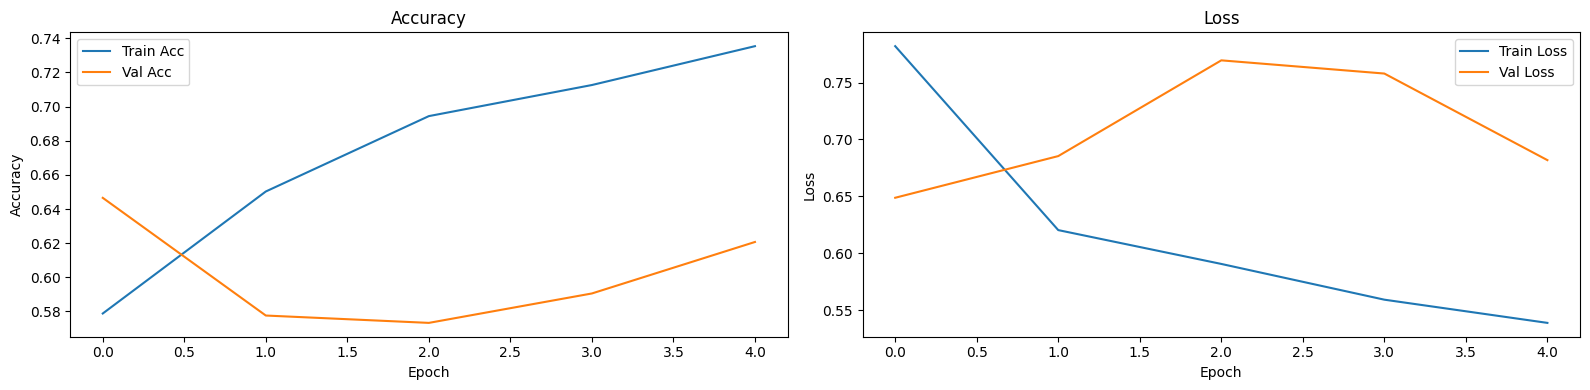

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


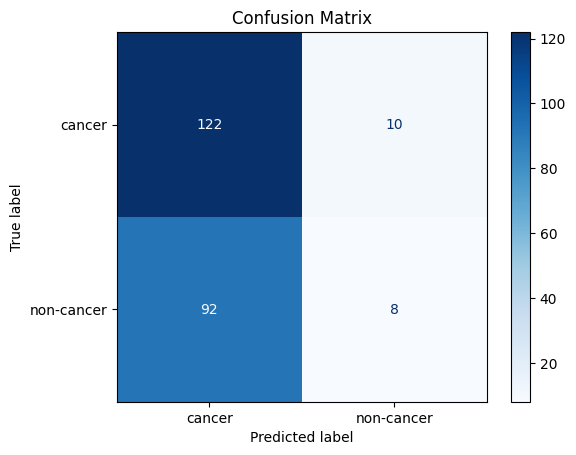

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Image prediction function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))  #  ResNet50 preprocess
    prediction = model.predict(img_array)

    if prediction[0][0] < 0.5:
        return "Cancer Detected"
    else:
        return "No Cancer Detected"

In [ ]:
# Test on new image
print(train_generator.class_indices)
img_path = r"/content/drive/MyDrive/Dataset-2/train/non-cancer/image_0001.jpg"

result = predict_image(img_path)
print(result)

{'cancer': 0, 'non-cancer': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
No Cancer Detected
